In [ ]:
## loading model

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [2]:
result = llm.invoke("Write a ballad about LangChain")
print(result.content)

The coder toiled, both late and long,
With datasets vast, a tangled throng.
To weave them 'round, a task so grand,
Required a tool, a helping hand.

He'd tried and failed, with many a scheme,
To extract sense, a flowing stream.
From scattered facts, a jumbled mess,
His weary soul knew no redress.

Then whispered winds, a rumour flew,
Of LangChain's might, a power new.
A framework bold, a shining star,
To bridge the gap, near and far.

With chains of thought, it built its way,
Through text and code, come what may.
LLMs it harnessed, swift and keen,
To make the data, sharply seen.

Its agents worked, with purpose clear,
To answer queries, far and near.
From simple tasks, to complex goals,
It solved the problems, filled the holes.

The memories held, the context known,
No information left alone.
Through chains it linked, a clever art,
To play its role, and do its part.

The coder smiled, his face alight,
For LangChain banished darkest night.
No longer lost, in data's maze,
He found his pa

- Create a Retriever now

In [46]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=20
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings,
    collection_name="rag-chroma",
    persist_directory="./chroma_db",  # new/empty folder
)
retriever = vectorstore.as_retriever()


In [47]:

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [48]:
# Testing the rag chain by running

question = "tell me about agent memory."
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

LLM-powered autonomous agents utilize two types of memory: short-term memory, which leverages in-context learning within the model's limited context window, and long-term memory, which uses an external vector store for storing and retrieving information over extended periods.  This external memory addresses the limitations of the finite context window in short-term memory.


In [49]:

question = "tell me about pahalgam attack on april 2025."
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

I don't know.  The provided text focuses on large language models and doesn't contain information about a Pahalgam attack in April 2025.


In [50]:
print(docs)

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

#### now create grade document class to assess

In [51]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [52]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [53]:
question = "tell me about the agent memory."
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [54]:
question = "tell me about the arjun sharkhar."
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


#### Create Question re-writer 

In [55]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [56]:
question_rewriter.invoke({"question": question})

'What is Arjun Sharkhar known for?'

- Needed Function

In [57]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print("---RETRIEVE---")
    
    question = state["question"]
    
    documents = retriever.invoke(question)
    
    return {"documents": documents, "question": question}

In [58]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [59]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

In [60]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"documents": documents, "question": better_question}

- Using Tavily for Web Crawling

In [61]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [62]:
from langchain.schema import Document
docs = web_search_tool.invoke({"query": "arjun vs karna"})
    
web_results = "\n".join([d["content"] for d in docs])
    
web_results = Document(page_content=web_results)

In [63]:
web_results

Document(metadata={}, page_content='Arjun and Karna, both were brothers. · Arjun was taught by DRONACHARYA while Karna was taught by god himself PARSHURAM. · Still, Arjun was\nIn this article, we delve into the awe-inspiring clash between two legendary warriors, Karna and Arjuna, an epic confrontation that stands as the pinnacle of the Mahabharata saga. This monumental battle unfolded on the 17th day of the Kurukshetra war, a day etched in history for its profound significance and the indomitable spirit of these two extraordinary heroes. After departing from the camp, Arjuna’s chariot raced toward the battlefield. As the fighting grounds drew nearer, he contemplated [...] Pandava soldiers urged Arjuna to defeat Karna and shatter Duryodhana’s dreams, while the Kauravas urged Karna to eliminate Arjuna and send the Pandavas into exile. Arjuna released a variety of arrows with different tips, and Karna countered with his own formidable arsenal. [...] In his anguish, Karna beseeched Arjuna,

In [64]:

from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d["content"] for d in docs])
    
    web_results = Document(page_content=web_results)
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [65]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

##### creating WorkFLow 

In [66]:
from langgraph.graph import END, StateGraph, START

In [67]:
from typing import List

from typing_extensions import TypedDict

In [68]:
class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

workflow= StateGraph(State)

In [69]:
# define the nodes
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

In [70]:
# Build graph
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [71]:
# Compile
app = workflow.compile()

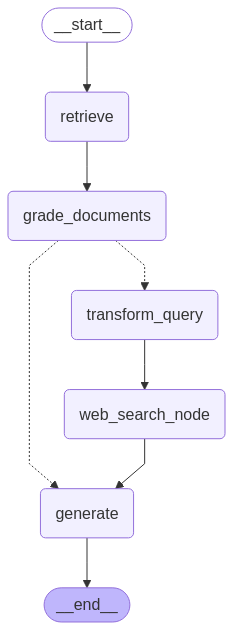

In [72]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [79]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the agent memory."}

In [80]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Agent memory encompasses short-term memory,  utilized through in-context '
 'learning, and long-term memory, which uses an external vector store for '
 'retaining and recalling information over extended periods.  This long-term '
 'memory enables the agent to access and retrieve information efficiently.')


In [86]:


for output in app.stream(input = {"question":"tell about lord PARSHURAM"}):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Lord Parashurama is the sixth avatar of the Hindu god Vishnu, also known as '
 'Rama with an axe.  He is a Brahmin warrior, the son of Renuka and Sage '
 'Jamadagni.  His birth is celebrated on Akshaya Tritiya.')
